In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import json
import networkx as nx
import time
import csv
import math
import random
import datetime
import errno
import os
import signal
import functools
import ast
import maup
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
maup.progress.enabled = True

import gerrychain
from gerrychain import Graph, Partition, Election
from gerrychain.updaters import Tally, cut_edges
from gerrychain import MarkovChain
from gerrychain.constraints import single_flip_contiguous
from gerrychain.proposals import propose_random_flip
from gerrychain.accept import always_accept
from gerrychain import (GeographicPartition, Partition, Graph, MarkovChain,
                        proposals, updaters, constraints, accept, Election)
from gerrychain.constraints.validity import within_percent_of_ideal_population
from gerrychain.metrics import mean_median,efficiency_gap
from gerrychain.proposals import recom
from functools import partial
from gerrychain.tree import (recursive_tree_part, random_spanning_tree, find_balanced_edge_cuts_memoization, 
                             PopulatedGraph, bipartition_tree, bipartition_tree_random, BalanceError)

from networkx.algorithms import tree
from networkx import is_connected, connected_components

from tqdm import tqdm

# Assorted helpers

In [2]:
# https://stackoverflow.com/questions/2281850
class TimeoutError(Exception):
    pass

def timeout(seconds=10, error_message=os.strerror(errno.ETIME)):
    def decorator(func):
        def _handle_timeout(signum, frame):
            raise TimeoutError(error_message)

        @functools.wraps(func)
        def wrapper(*args, **kwargs):
            signal.signal(signal.SIGALRM, _handle_timeout)
            signal.alarm(seconds)
            try:
                result = func(*args, **kwargs)
            finally:
                signal.alarm(0)
            return result

        return wrapper

    return decorator

# Define functions for game

In [3]:
#pick player to go first based on "coin flip"
def choosePlayer(party1, party2):
    flip = random.randint(0, 1)
    if (flip == 0):
        player = party1
    elif (flip == 1):
        player = party2
    return player

# Get next player given current player
def nextPlayer(currentPlayer):
    if (currentPlayer == "Democrat"):
        return "Republican" 
    else:
        return "Democrat"

In [4]:
#set seed plan
def seedPlan(graph, total_pop, num_districts):
    pop_bound = 0.005
    seed = recursive_tree_part(graph, range(num_districts), total_pop/num_districts,"TOTPOP", 0.8*pop_bound, 2)
    seed_partition = GeographicPartition(graph, assignment=seed, updaters={
            "cut_edges": cut_edges,
            "population": Tally(POPULATION_COL, alias="population"),
            "TRE18": ELECTION
        })
    return seed_partition

In [18]:
# Adaptation of GerryChain bipartition_tree avoiding getting stuck
# Used in Catherine's thesis
def bipartition_tree_bounded_repeats(
    graph,
    pop_col,
    pop_target,
    epsilon,
    node_repeats=10,
    spanning_tree=None,
    spanning_tree_fn=random_spanning_tree,
    balance_edge_fn=find_balanced_edge_cuts_memoization,
    choice=random.choice,
    repeats=1000
):
    populations = {node: graph.nodes[node][pop_col] for node in graph}
    possible_cuts = []
    if spanning_tree is None:
        spanning_tree = spanning_tree_fn(graph)
    restarts = 0
    for _ in range(repeats):
        if len(possible_cuts) > 0:
            return choice(possible_cuts).subset
        if restarts == node_repeats:
            spanning_tree = spanning_tree_fn(graph)
            restarts = 0
        h = PopulatedGraph(spanning_tree, populations, pop_target, epsilon)
        possible_cuts = balance_edge_fn(h, choice=choice)
        restarts += 1
    return None   # failed to find a balanced cut after repeats

# Adaptation of GerryChain recom method
# Used in Catherine's thesis
def recom_with_self_loops(
    partition, pop_col, pop_target, epsilon, node_repeats=1, method=bipartition_tree
):
    edge = random.choice(tuple(partition["cut_edges"]))
    parts_to_merge = (partition.assignment[edge[0]], partition.assignment[edge[1]])

    subgraph = partition.graph.subgraph(
        partition.parts[parts_to_merge[0]] | partition.parts[parts_to_merge[1]]
    )

    try:
        flips = recursive_tree_part(
            subgraph,
            parts_to_merge,
            pop_col=pop_col,
            pop_target=pop_target,
            epsilon=epsilon,
            node_repeats=node_repeats,
            method=method,
        )
    except BalanceError:
        flips = {}
    return partition.flip(flips)

In [19]:
# Function to run chain on seed_partition
# Returns num_parts parts as generator, with given spacing between parts
def runChains(seed_partition, num_districts, ideal_pop, num_parts=3, spacing=1, show_progress_bar = True):
    num_steps = num_parts * spacing
    basic_proposal = partial(recom_with_self_loops, 
                         pop_col= POPULATION_COL, 
                         pop_target= ideal_pop, 
                         epsilon=0.005,  
                         node_repeats=10,
                         method=bipartition_tree_bounded_repeats)
    basic_chain = MarkovChain(proposal=basic_proposal,
                          constraints=[constraints.within_percent_of_ideal_population(seed_partition, 0.025)],
                          accept=accept.always_accept,
                          initial_state=seed_partition,
                          total_steps=num_steps)
    
    if (show_progress_bar):
        basic_chain = basic_chain.with_progress_bar()
        
    counter = 1
    for part in basic_chain:
        if (counter % spacing == 0):
            yield part
        counter = counter +1

In [20]:
# Function to select district by percent.
# This particular algorithm tries to choose the district ID by
#  1. Closest to 55, if there are any percentages > 50
#  2. Smallest percentage, if there are no percentages > 0
# Df should have two columns: dist_ID and pct
# returns int
def selectDistrictByPercentage(df):
    sorted55 = df.sort_values(by='pct', key=lambda x: abs(0.55-x))
    #print(sorted55.pct)
    for i in range(len(sorted55)):
        close55 = sorted55.iloc[i]
            
        if close55['pct'] < 0.51: 
            if i+1 == len(sorted55):
                temp = sorted55.sort_values(by='pct')
                close55 = temp.iloc[0]
                return close55
        else:
            return close55

In [21]:
# Some tests for selectDistrictByPercentage
# Standard
df = pd.DataFrame({'dist_ID': [1, 2, 3], 'pct': [0.45, 0.56, 0.50]})
assert(selectDistrictByPercentage(df)['dist_ID'] == 2), "Standard case should return closest to 55"

df = pd.DataFrame({'dist_ID': [1, 2, 3, 4], 'pct': [0.45, 0.56, 0.58, 0.50]})
assert(selectDistrictByPercentage(df)['dist_ID'] == 2), "Standard case should return closest to 55"

df = pd.DataFrame({'dist_ID': [1, 2, 3, 4, 5], 'pct': [0.58, 0.58, 0.56, 0.55, 0.50]})
assert(selectDistrictByPercentage(df)['dist_ID'] == 4), "Standard case should return closest to 55"

df = pd.DataFrame({'dist_ID': [1, 2, 3, 4, 5], 'pct': [0.12, 0.64, 0.65, 0.63, 0.90]})
assert(selectDistrictByPercentage(df)['dist_ID'] == 4), "Standard case should return closest to 55"

df = pd.DataFrame({'dist_ID': [1], 'pct': [0.01]})
assert(selectDistrictByPercentage(df)['dist_ID'] == 1), "Standard case should return closest to 55"

df = pd.DataFrame({'dist_ID': [1, 2], 'pct': [0.45, 0.50]})
assert(selectDistrictByPercentage(df)['dist_ID'] == 1), "All < 51 case should return smallest"

df = pd.DataFrame({'dist_ID': [1, 2, 3], 'pct': [0.45, 0.50, 0.12]})
assert(selectDistrictByPercentage(df)['dist_ID'] == 3), "All < 51 case should return smallest"

In [23]:
# From a list of parts, build dataframe of all districts
def buildDistrictsDataframe(parts, num_districts, percent_key):
    pcts_all = []
    for (idx, part) in enumerate(parts):
        # We should check that this ordering works
        pcts = {'dist_ID': range(num_districts), 'pct': part["TRE18"].percents(percent_key), 'part_idx': idx} 
        pcts_all.append(pd.DataFrame(data=pcts))

    pcts_df = pd.concat(pcts_all)
    return pcts_df

def playerToPercentKey(player):
    percent_key = "Dem"
    if (player == "Republican"):
        percent_key = "Rep"
    return percent_key

# Takes a list of GeographicPartition in parts, current player and num_districts and returns selected partition and district number
def selectDistrict(parts, player, num_districts):
    percent_key = playerToPercentKey(player)

    pcts_df = buildDistrictsDataframe(parts, num_districts, percent_key) 
    row = selectDistrictByPercentage(pcts_df)
    return (parts[int(row['part_idx'])], row['dist_ID'], row['pct'])

In [24]:
# For a given GeographicPartition and district number, return useful data
def getDistrictMetadata(part, dist_num):
    #access nodes for the district number
    district_nodes = part.parts.get(dist_num)
    #get subset of dictionary for only one district
    pop_district = part["population"].get(dist_num)
    assignment = part.assignment
    a_subset = {key: value for key, value in assignment.items() if value == dist_num}
    return (district_nodes, pop_district, assignment, a_subset)

## Recursive function to play game

In [25]:
# Main recursive game function
def game(graph, total_pop, num_districts, player, num_choices_per_turn, steps_between_choice):
    def buildNodeAssignmentMap(nodes, district_num):
        d = {}
        for node in nodes:
            d[node] = district_num
        return d
    def mergeDicts(d1, d2):
        return {**d1, **d2}
        
    #set number of precincts in current graph
    num_precincts = graph.number_of_nodes()

    #not sure if these are things I would need to set or initialize outside the function?
    ideal_pop = int(round(total_pop/num_districts))
    
    #set initial partition, will graph and pop_bound b 
    seed_partition = seedPlan(graph, total_pop, num_districts)

    # Each part is a GeographicPartition https://gerrychain.readthedocs.io/en/latest/api.html#gerrychain.partition.GeographicPartition
    parts_gen = runChains(seed_partition, num_districts, ideal_pop, num_choices_per_turn, steps_between_choice, show_progress_bar=False)
    parts = list(parts_gen) # Fine for a small number of parts
    
    #player chooses district to freeze
    part, district_num, percent = selectDistrict(parts, player, num_districts)
    # Checking to make sure the district selection process is mapping a winning percent back to the correct district in the correct part
    # Sanity check
    assert(part["TRE18"].percents(playerToPercentKey(player))[int(district_num)] == percent), "Percent of district should be equal to percent returned from district selection"
    
    district_nodes, pop_district, assignment, a_subset = getDistrictMetadata(part, district_num)
        
    #remove frozen district's nodes 
    graph.remove_nodes_from(district_nodes)
        
    #reset stuff for next iteration 
    new_num_districts = num_districts - 1
    new_total_pop = total_pop - (int(pop_district))
    
    # NEED TO UNCOMMENT
    #player = nextPlayer(player)
    
    # Collate results
    resultsAssign = buildNodeAssignmentMap(district_nodes, num_districts)
    
    #end game when there's only one district left
    # Base case
    if new_num_districts == 1:
        # Get last assignment
        resultsAssignLast = buildNodeAssignmentMap(graph.nodes, num_districts-1)
        return mergeDicts(resultsAssign, resultsAssignLast)
    # Recursive case
    else:
        recursiveResultsAssign = game(graph, new_total_pop, new_num_districts, player, num_choices_per_turn, steps_between_choice)
        return mergeDicts(resultsAssign, recursiveResultsAssign)


# Making the game happen 

## Importing the Wisconsin geodata 

In [12]:
#load precinct file and graph
WI_shp_path = ""
precincts_WI = gpd.read_file(WI_shp_path)

In [13]:
#define initial graph
startGraph = Graph.from_geodataframe(precincts_WI)

/Users/alexray/miniconda3/envs/gerryProject/lib/python3.10/site-packages/gerrychain/graph/adjacency.py:21: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  geometries[i].id = i
/Users/alexray/miniconda3/envs/gerryProject/lib/python3.10/site-packages/gerrychain/graph/graph.py:238: UserWarning: Found islands (degree-0 nodes). Indices of islands: {1518, 63}
  warnings.warn(
/Users/alexray/miniconda3/envs/gerryProject/lib/python3.10/site-packages/gerrychain/graph/graph.py:272: UserWarning: NA values found in column Code!
  warnings.warn("NA values found in column {}!".format(column))


In [26]:
# see https://gerrychain.readthedocs.io/en/latest/user/islands.html for walkthrough
def connectIslandsInStartGraph():
    def find_node_by_code(code):
        for node in startGraph:
            if startGraph.nodes[node]["Code"] == code:
                return node
            
    # Codes from QGIS
    top_left_island_code = 55003425620001
    top_left_island_node = find_node_by_code(top_left_island_code)
    top_left_island_neighbor_codes = [55007703000001, 55007703000002, 55007053750001, 55003713500001, 55007054750001]

    top_right_island_code = 55029836000001
    top_right_island_node = find_node_by_code(top_right_island_code)
    top_right_island_neighbor_codes = [55029439250001]

    for nc in top_left_island_neighbor_codes:
        startGraph.add_edge(top_left_island_node, find_node_by_code(nc))
    for nc in top_right_island_neighbor_codes:
        startGraph.add_edge(top_right_island_node, find_node_by_code(nc))
        
connectIslandsInStartGraph()
assert(is_connected(startGraph) == True), "Not connected when it should be"

## Framework to run game

In [27]:
#set election we're working with
ELECTION = Election("TRE18", {"Dem": "TRE18D", "Rep": "TRE18R"})
POPULATION_COL = "TOTPOP"

# Wrapper function for game
@timeout(180) # can optionally comment out. Will need to change for more choices/steps
def runGame(num_choices_per_turn=1, steps_between_choice=1, player=None):
    #set initial number of districts 
    init_num_districts = 8

    #set initial population, will game function recognize this 
    init_pop = int(round(precincts_WI["TOTPOP"].sum()))

    # it looks like this population bound is a percentage fluctuation from the ideal 
    # population of a district, so I dont think (?) we need to change it as the number 
    # of districts decreases
    pop_bound = 0.005
    
    #set player to go first
    if player == None:
        player = choosePlayer("Democrat", "Republican")
    #player = "Democrat"

    # game function mutates the graph object
    # This lets us re-run without re-reading in from the shape file
    graph = startGraph.copy()

    return player, game(graph, init_pop, init_num_districts, player, num_choices_per_turn, steps_between_choice)

def runGamesWithStats(num_games = 1, num_choices_per_turn = 1, steps_between_choice = 1):
    game_percents = []
    game_count_won = []
    starting_player = []
    
    for i in range(0, num_games):
        print(f"Running game: {i}")
        try:
            player, result = runGame(num_choices_per_turn, steps_between_choice)
            result_part = Partition(startGraph, result, updaters={"cut_edges": cut_edges, "TRE18": ELECTION})
            percents = list(result_part["TRE18"].percents("Dem"))
            game_percents.append(percents)
            game_count_won.append(sum([1 if i > 0.5 else 0 for i in percents]))
            starting_player.append(player)
        except TimeoutError:
            continue
    
    df = pd.DataFrame({'percents': game_percents, 'count_won': game_count_won, 'starting_player': starting_player})
    return df

## Very basic game tests

In [217]:
player, result = runGame(player="Republican")

5    0.533259
2    0.568409
6    0.569075
3    0.527022
0    0.525880
7    0.505568
4    0.319242
1    0.295167
Name: pct, dtype: float64
4    0.488115
2    0.480076
6    0.456746
1    0.449343
3    0.438516
0    0.679869
5    0.700974
Name: pct, dtype: float64
3    0.559913
1    0.562214
0    0.523443
4    0.507072
5    0.442074
2    0.367351
Name: pct, dtype: float64
4    0.579533
1    0.493253
3    0.618026
0    0.476499
2    0.432880
Name: pct, dtype: float64
0    0.567534
1    0.523119
2    0.507307
3    0.381329
Name: pct, dtype: float64
0    0.492985
1    0.620325
2    0.475360
Name: pct, dtype: float64
1    0.524513
0    0.507116
Name: pct, dtype: float64


In [218]:
# Testing to make sure nodes that went in are the nodes that come out
expected_nodes = sorted(startGraph.nodes)
got_nodes = sorted(list(result.keys()))

print(len(got_nodes))
assert(len(expected_nodes) == len(got_nodes)), "Lengths match"
assert(expected_nodes == got_nodes), "Nodes match"

# Seeing if percents make sense
result_part = Partition(startGraph, result, updaters={"cut_edges": cut_edges, "TRE18": ELECTION})
result_part["TRE18"].percents("Dem")

7078


(0.46674146448835846,
 0.6798690154893218,
 0.4400872837671168,
 0.5795328280092729,
 0.432465952306779,
 0.620325346879317,
 0.4754868675662838,
 0.4928842912383911)

# Generating stats

Currently, stats dataframes have two columns: list of percents and count of num districts won

## Generate game stats

In [236]:
def saveGameStatsFile(df):
    path = "./wi_game_data_single_player"
    if (not os.path.exists(path)):
        os.makedirs(path)
    
    current_datetime_str = '{date:%Y-%m-%dT%H-%M-%S}'.format(date=datetime.datetime.now())
    df.to_csv(f'{path}/wi_game_stats_{current_datetime_str}_{len(df.index)}.csv')

In [241]:
df = runGamesWithStats(200, 1, 1)
saveGameStatsFile(df)

Running game: 0
Running game: 1
Running game: 2
Running game: 3
Running game: 4
Running game: 5
Running game: 6
Running game: 7
Running game: 8
Running game: 9
Running game: 10
Running game: 11
Running game: 12
Running game: 13
Running game: 14
Running game: 15
Running game: 16
Running game: 17
Running game: 18
Running game: 19
Running game: 20
Running game: 21
Running game: 22
Running game: 23
Running game: 24
Running game: 25
Running game: 26
Running game: 27
Running game: 28
Running game: 29
Running game: 30
Running game: 31
Running game: 32
Running game: 33
Running game: 34
Running game: 35
Running game: 36
Running game: 37
Running game: 38
Running game: 39
Running game: 40
Running game: 41
Running game: 42
Running game: 43
Running game: 44
Running game: 45
Running game: 46
Running game: 47
Running game: 48
Running game: 49
Running game: 50
Running game: 51
Running game: 52
Running game: 53
Running game: 54
Running game: 55
Running game: 56
Running game: 57
Running game: 58
Running

## Generate null

In [27]:
graph = startGraph.copy()
num_districts = 8
total_pop = int(round(precincts_WI["TOTPOP"].sum()))
#set initial partition, will graph and pop_bound
seed_partition = seedPlan(graph, total_pop, num_districts)

ideal_pop = int(round(total_pop/num_districts))

In [28]:
# Wrapper for runChains that returns a dataframe of relevant stats
def runChainsWithStats(seed_partition, num_districts, ideal_pop, num_parts=3, spacing=1):
    step_percents = []
    step_count_won = []
    for part in runChains(seed_partition, num_districts, ideal_pop, num_parts, spacing):
        percents = list(part["TRE18"].percents("Dem"))
        step_percents.append(percents)
        step_count_won.append(sum([1 if i > 0.5 else 0 for i in percents]))
    
    df = pd.DataFrame({'percents': step_percents, 'count_won': step_count_won})
    return df

def saveNullStatsFile(df):
    path = "./wi_null_data"
    if (not os.path.exists(path)):
        os.makedirs(path)
    
    current_datetime_str = '{date:%Y-%m-%dT%H-%M-%S}'.format(date=datetime.datetime.now())
    df.to_csv(f'{path}/wi_chain_stats_{current_datetime_str}_{len(df.index)}.csv')

In [29]:
df = runChainsWithStats(seed_partition, num_districts, ideal_pop, num_parts=1000, spacing=10)
saveNullStatsFile(df)

  0%|          | 0/10000 [00:00<?, ?it/s]

# Plotting

## Maps

### Map of 2018 election

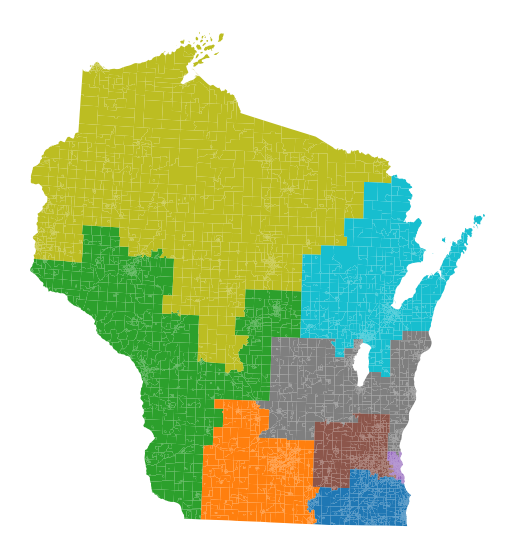

In [46]:
part = Partition(
    startGraph, 
    assignment="CD", # https://github.com/mggg-states/WI-shapefiles#metadata
    updaters={"cut_edges": cut_edges, "TRE18": ELECTION})

part.plot(figsize=(10, 10))
plt.box(False)
plt.xticks([])
plt.yticks([])
plt.savefig("figures/realWI.png")

### Map of example game run

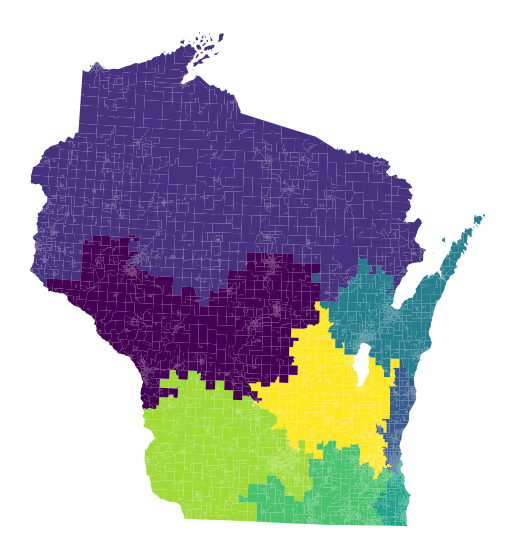

In [51]:
_, result = runGame()
part = Partition(startGraph, result, updaters={"cut_edges": cut_edges, "TRE18": ELECTION})

part.plot(figsize=(10, 10))
plt.box(False)
plt.xticks([])
plt.yticks([])
plt.savefig("figures/exampleWI.png")

## Histograms

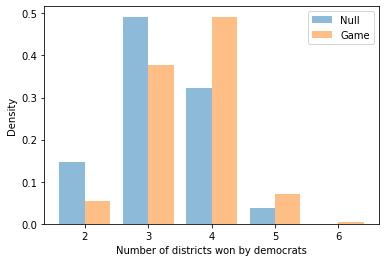

In [267]:
df1 = pd.read_csv("./wi_null_data/wi_chain_stats_2022-04-29T16-28-50_10000.csv", header=0)
#df = pd.read_csv("./wi_null_data/wi_chain_stats_2022-04-10T19-02-45_1000.csv", header=0)
#df.count_won.plot(kind='density', label="Null")
#plt.hist(df.count_won, density=True, label="Null", alpha=0.5)

df2 = pd.read_csv("./wi_game_data/wi_game_combined_5_1.csv", header=0)
plt.hist([df1.count_won, df2.count_won], density=True, alpha=0.5, label=['Null', 'Game'], bins=[1.5, 2.5, 3.5, 4.5, 5.5, 6.5])
#df.count_won.plot(kind='density', label="Game", ax=plt.gca())


plt.ylabel("Density")
plt.xlabel("Number of districts won by democrats")
plt.legend()
plt.savefig("./figures/null_game_districts_won_comparison.png")

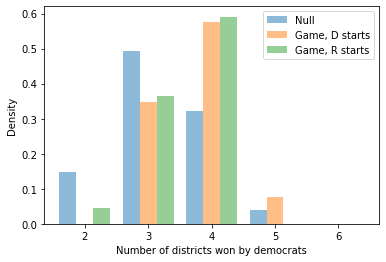

In [17]:
df1 = pd.read_csv("../wi_null_data/wi_chain_stats_2022-04-29T16-28-50_10000.csv", header=0)
#df.count_won.plot(kind='density', label="Null")

df2 = pd.read_csv("../wi_game_data_more_options/wi_game_stats_2022-05-02T02-36-00_48.csv", header=0)
#df2 = pd.read_csv("./wi_game_data_single_player/wi_game_stats_2022-05-02T09-28-24_192.csv", header=0, converters={1:ast.literal_eval})
#df.loc[df.starting_player == "Democrat"].count_won.plot(kind='density', label="Game, democrat starts", ax=plt.gca())
#df.loc[df.starting_player == "Republican"].count_won.plot(kind='density', label="Game, republican starts", ax=plt.gca())

plt.hist([df1.count_won, df2.loc[df2.starting_player == "Democrat"].count_won, df2.loc[df2.starting_player == "Republican"].count_won], density=True, alpha=0.5, label=['Null', 'Game, D starts', 'Game, R starts'], bins=[1.5, 2.5, 3.5, 4.5, 5.5, 6.5])


plt.ylabel("Density")
plt.xlabel("Number of districts won by democrats")
plt.legend()
plt.savefig("./figures/null_game_districts_won_comparison_by_starting_player_multi_choice.png")

### Chain number districts dems win

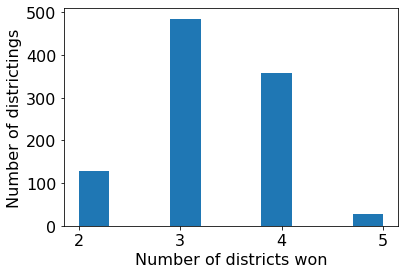

In [20]:
df = pd.read_csv("./wi_null_data/wi_chain_stats_2022-04-10T19-02-45_1000.csv", header=0)

# Note: looks like garbage, need to fix
plt.hist(df.count_won)
plt.yticks(fontsize=16)
plt.xticks([2, 3, 4, 5], fontsize=16)
plt.ylabel("Number of districtings", fontsize=16)
plt.xlabel("Number of districts won", fontsize=16)
plt.show()

### Game number districts dems win

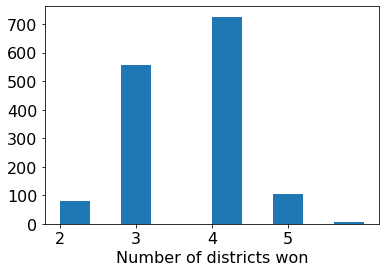

In [161]:
df = pd.read_csv("./wi_game_data/wi_game_combined_5_1.csv", header=0)

plt.hist(df.count_won)
plt.yticks(fontsize=16)
plt.xticks([2, 3, 4, 5], fontsize=16)
#plt.ylabel("Number of districtings", fontsize=16)
plt.xlabel("Number of districts won", fontsize=16)
plt.show()

### Chain winning margin (abs)

(array([1896., 1977., 1410.,  645.,  354.,  312.,  343.,  750.,  234.,
          79.]),
 array([2.71219755e-05, 2.67197141e-02, 5.34123063e-02, 8.01048984e-02,
        1.06797491e-01, 1.33490083e-01, 1.60182675e-01, 1.86875267e-01,
        2.13567859e-01, 2.40260451e-01, 2.66953043e-01]),
 <BarContainer object of 10 artists>)

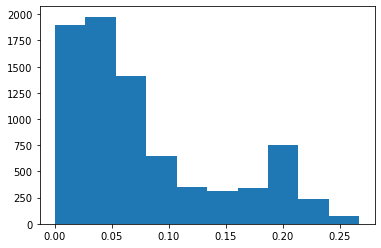

In [33]:
# ast literal eval lets percents load as a list rather than generic object
df = pd.read_csv("./wi_null_data/wi_chain_stats_2022-04-10T19-02-45_1000.csv", header=0, converters={1:ast.literal_eval})
df = df.explode('percents')
df = df.rename(columns={'percents': 'percent'})
df['margin'] = df.apply (lambda row: abs(0.5-row.percent), axis=1)

plt.hist(df.margin)

### Game winning margin (abs)

(array([2410., 3751., 2174.,  821.,  563.,  507.,  557.,  817.,  159.,
          57.]),
 array([3.28543174e-06, 2.66983351e-02, 5.33933848e-02, 8.00884344e-02,
        1.06783484e-01, 1.33478534e-01, 1.60173583e-01, 1.86868633e-01,
        2.13563683e-01, 2.40258732e-01, 2.66953782e-01]),
 <BarContainer object of 10 artists>)

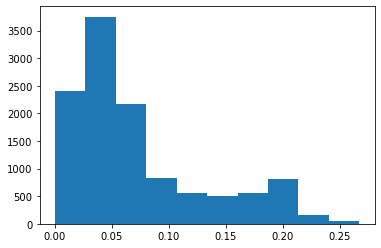

In [162]:
# ast literal eval lets percents load as a list rather than generic object
df = pd.read_csv("./wi_game_data/wi_game_combined_5_1.csv", header=0, converters={1:ast.literal_eval})
df = df.explode('percents')
df = df.rename(columns={'percents': 'percent'})
df['margin'] = df.apply (lambda row: abs(0.5-row.percent), axis=1)

plt.hist(df.margin)

### Chain winning margin

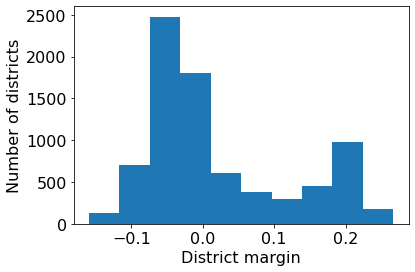

8000

In [175]:
# ast literal eval lets percents load as a list rather than generic object
df = pd.read_csv("./wi_null_data/wi_chain_stats_2022-04-10T19-02-45_1000.csv", header=0, converters={1:ast.literal_eval})
df = df.explode('percents')
df = df.rename(columns={'percents': 'percent'})
df['margin'] = df.apply (lambda row: row.percent - 0.5, axis=1)

plt.hist(df.margin)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.ylabel("Number of districts", fontsize=16)
plt.xlabel("District margin", fontsize=16)
plt.show()

len(df.margin)

### Game winning margin

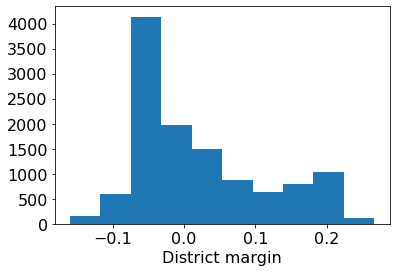

In [163]:
# ast literal eval lets percents load as a list rather than generic object
df = pd.read_csv("./wi_game_data/wi_game_combined_5_1.csv", header=0, converters={1:ast.literal_eval})
df = df.explode('percents')
df = df.rename(columns={'percents': 'percent'})
df['margin'] = df.apply (lambda row: row.percent - 0.5, axis=1)

plt.hist(df.margin)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
#plt.ylabel("Number of districtings", fontsize=16)
plt.xlabel("District margin", fontsize=16)
plt.show()

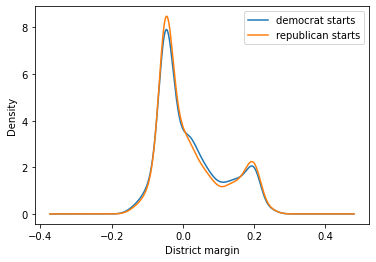

In [181]:
df = pd.read_csv("./wi_game_data/wi_game_combined_5_1.csv", header=0, converters={1:ast.literal_eval})
df = df.explode('percents')
df = df.rename(columns={'percents': 'percent'})
df['margin'] = df.apply (lambda row: row.percent - 0.5, axis=1)

df.loc[df.starting_player == "Democrat"].margin.plot(kind='density', label="democrat starts")
df.loc[df.starting_player == "Republican"].margin.plot(kind='density', label="republican starts", ax=plt.gca())
plt.xlabel("District margin")
plt.ylabel("Density")
plt.legend()
plt.savefig("./figures/game_margin_comparison_by_starting_player.png")

2876


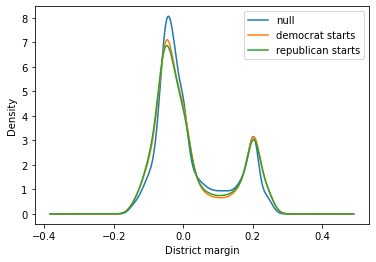

In [291]:
df = pd.read_csv("./wi_null_data/wi_chain_stats_2022-04-29T16-28-50_10000.csv", header=0, converters={1:ast.literal_eval})
df = df.explode('percents')
df = df.rename(columns={'percents': 'percent'})
df['margin'] = df.apply (lambda row: row.percent - 0.5, axis=1)
df.margin.plot(kind='density', label="null")

df = pd.read_csv("./wi_game_data_buggy/wi_game_combined_4_30.csv", header=0, converters={1:ast.literal_eval})
#df = pd.read_csv("./wi_game_data_single_player/wi_game_stats_2022-05-02T09-28-24_192.csv", header=0, converters={1:ast.literal_eval})
print(len(df.loc[df.starting_player == "Democrat"]))
df = df.explode('percents')
df = df.rename(columns={'percents': 'percent'})
df['margin'] = df.apply (lambda row: row.percent - 0.5, axis=1)

df.loc[df.starting_player == "Democrat"].margin.plot(kind='density', label="democrat starts", ax=plt.gca())
df.loc[df.starting_player == "Republican"].margin.plot(kind='density', label="republican starts", ax=plt.gca())
plt.xlabel("District margin")
plt.ylabel("Density")
plt.legend()
plt.savefig("./figures/null_game_margin_comparison_by_starting_player_maximizing.png")

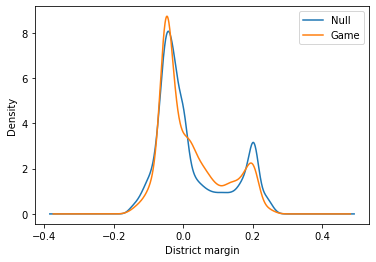

In [254]:
df = pd.read_csv("./wi_null_data/wi_chain_stats_2022-04-29T16-28-50_10000.csv", header=0, converters={1:ast.literal_eval})
df = df.explode('percents')
df = df.rename(columns={'percents': 'percent'})
df['margin'] = df.apply (lambda row: row.percent - 0.5, axis=1)
df.margin.plot(kind='density', label="Null")

df = pd.read_csv("./wi_game_data/wi_game_combined_5_1.csv", header=0, converters={1:ast.literal_eval})
df = df.explode('percents')
df = df.rename(columns={'percents': 'percent'})
df['margin'] = df.apply (lambda row: row.percent - 0.5, axis=1)

df.margin.plot(kind='density', label="Game", ax=plt.gca())
plt.xlabel("District margin")
plt.ylabel("Density")
plt.legend()
plt.savefig("./figures/null_game_margin_comparison.png")

In [288]:
df = pd.read_csv("./wi_game_data/wi_game_combined_5_1.csv", header=0, converters={1:ast.literal_eval})
df = df.loc[df.starting_player == "Democrat"]

tmp = []
tmp_std = []
for i in range(8):
    percents = [a[i] for a in df.percents]
    tmp.append(np.mean(percents))
    tmp_std.append(np.std(percents))

print(tmp)
print(tmp_std)

[0.5785710828709881, 0.4507280665702868, 0.5981242359995609, 0.45189718827635045, 0.6138547602424494, 0.45061426837597524, 0.5425924484153012, 0.4744402661138835]
[0.06270171486718393, 0.008685387368541944, 0.06573515168117965, 0.01140171355815393, 0.08531244580375431, 0.03153505745480969, 0.1121418016726318, 0.0460926635415488]


In [287]:
df = pd.read_csv("./wi_game_data/wi_game_combined_5_1.csv", header=0, converters={1:ast.literal_eval})
df = df.loc[df.starting_player == "Republican"]

tmp = []
tmp_std = []
for i in range(8):
    percents = [a[i] for a in df.percents]
    tmp.append(np.mean(percents))
    tmp_std.append(np.std(percents))

print(tmp)
print(tmp_std)

[0.45058085727069547, 0.5844102447012022, 0.45195210545712294, 0.6070155139230538, 0.4519142503509825, 0.6062363957234564, 0.47217629974943504, 0.5354665759061349]
[0.008164156972726072, 0.0671441071026795, 0.011213086635250363, 0.07010649037839585, 0.027912114445543548, 0.09453449384583724, 0.07411156363546852, 0.08581730246580478]


(array([198., 156., 119.,  65.,  33.,  16.,  25.,  23.,  48.,  74.]),
 array([0.5100924 , 0.53058122, 0.55107004, 0.57155886, 0.59204768,
        0.6125365 , 0.63302532, 0.65351414, 0.67400296, 0.69449178,
        0.7149806 ]),
 <BarContainer object of 10 artists>)

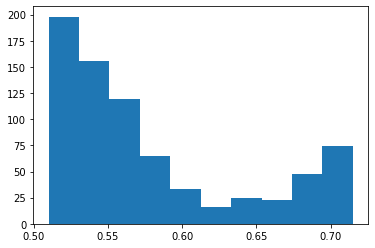

In [289]:
df = pd.read_csv("./wi_game_data/wi_game_combined_5_1.csv", header=0, converters={1:ast.literal_eval})
df = df.loc[df.starting_player == "Democrat"]

percents = [a[0] for a in df.percents]

plt.hist(percents)

(array([  6.,  20.,  44.,  97., 184., 197., 117.,  41.,  11.,   3.]),
 array([0.42356416, 0.42897506, 0.43438597, 0.43979687, 0.44520777,
        0.45061867, 0.45602957, 0.46144048, 0.46685138, 0.47226228,
        0.47767318]),
 <BarContainer object of 10 artists>)

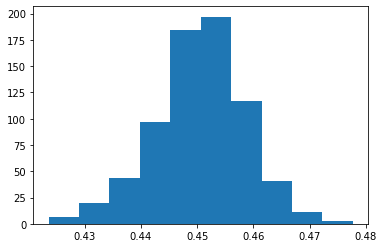

In [290]:
df = pd.read_csv("./wi_game_data/wi_game_combined_5_1.csv", header=0, converters={1:ast.literal_eval})
df = df.loc[df.starting_player == "Republican"]

percents = [a[0] for a in df.percents]

plt.hist(percents)

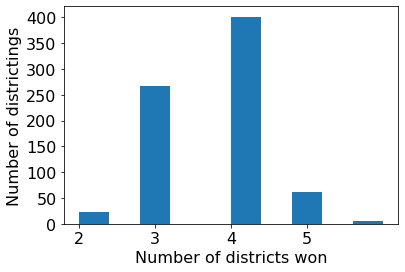

In [166]:
df = pd.read_csv("./wi_game_data/wi_game_combined_5_1.csv", header=0)

plt.hist(df.loc[df.starting_player == "Democrat"].count_won)
plt.yticks(fontsize=16)
plt.xticks([2, 3, 4, 5], fontsize=16)
plt.ylabel("Number of districtings", fontsize=16)
plt.xlabel("Number of districts won", fontsize=16)
plt.show()

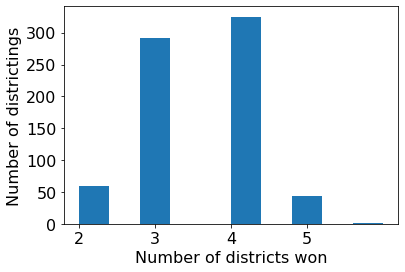

In [167]:
df = pd.read_csv("./wi_game_data/wi_game_combined_5_1.csv", header=0)

plt.hist(df.loc[df.starting_player == "Republican"].count_won)
plt.yticks(fontsize=16)
plt.xticks([2, 3, 4, 5], fontsize=16)
plt.ylabel("Number of districtings", fontsize=16)
plt.xlabel("Number of districts won", fontsize=16)
plt.show()

In [97]:
results = []
for i in range(10):
    _, result = runGame()
    results.append(result)

dist_ID     1.000000
pct         0.728175
part_idx    0.000000
Name: 1, dtype: float64
dist_ID     1.00000
pct         0.60977
part_idx    0.00000
Name: 1, dtype: float64
dist_ID     5.000000
pct         0.675905
part_idx    0.000000
Name: 5, dtype: float64
dist_ID     4.00000
pct         0.56057
part_idx    0.00000
Name: 4, dtype: float64
dist_ID     3.000000
pct         0.553349
part_idx    0.000000
Name: 3, dtype: float64
dist_ID     2.000000
pct         0.542762
part_idx    0.000000
Name: 2, dtype: float64
dist_ID     1.000000
pct         0.459456
part_idx    0.000000
Name: 1, dtype: float64
dist_ID     1.000000
pct         0.736967
part_idx    0.000000
Name: 1, dtype: float64
dist_ID     2.000000
pct         0.607428
part_idx    0.000000
Name: 2, dtype: float64
dist_ID     5.00000
pct         0.67775
part_idx    0.00000
Name: 5, dtype: float64
dist_ID     4.000000
pct         0.557914
part_idx    0.000000
Name: 4, dtype: float64
dist_ID     1.000000
pct         0.465764
part_idx  

In [119]:
# https://www.statology.org/jaccard-similarity-python/
def jaccard(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection) / union

s1 = {k for k,v in results[0].items() if v == 8} 
s2 = {k for k,v in results[9].items() if v == 8} 

In [120]:
jaccard(s1, s2)

0.0